# Equipment Failure Prediction Model

## Overview
Notebook ini mengembangkan model prediksi breakdown alat berat untuk sistem predictive maintenance. Model binary classification ini mengidentifikasi alat yang berisiko tinggi mengalami breakdown dalam periode mendatang.

## Business Objective
**Goal**: Memprediksi breakdown alat berat sebelum terjadi untuk maintenance planning proaktif

**Primary KPI**: **Recall > 0.80** (minimize missed breakdowns - false negatives)
- False negative = breakdown tidak terdeteksi = unplanned downtime + biaya tinggi
- Early detection = scheduled maintenance = reduced operational disruption

**Secondary KPIs**:
- Precision > 0.60 (mengurangi false alarms)
- F1-Score > 0.70 (balanced performance)
- ROC-AUC > 0.85 (discrimination power)

## Model Information
- **Algorithm**: XGBoost Classifier (gradient boosting untuk imbalanced data)
- **Problem Type**: Binary Classification (Breakdown vs Beroperasi)
- **Class Imbalance Strategy**: SMOTE resampling + scale_pos_weight
- **Feature Engineering**: 38 engineered features dari Fleet Features notebook
  - Age features: equipment_age_years, umur_bulan
  - Usage features: utilization_rate, produktivitas_relatif
  - Maintenance features: breakdown_rate_30d, days_since_last_maintenance
  - Health score: composite_health_score (0-100)

## Data Source
- **Feature Store**: `data/feature_store/fleet_features.parquet`
- **Target Variable**: `breakdown_flag` (created from status_operasi)
  - 1 = Breakdown (high-risk equipment)
  - 0 = Beroperasi (operational equipment)
- **Key Features**:
  - Equipment characteristics: tipe_alat, kapasitas_ton
  - Operational metrics: jam_operasi, jarak_tempuh_km
  - Maintenance history: jml_breakdown, jml_maintenance
  - Performance indicators: utilization_rate, reliability_index

## MLflow Configuration
- **Tracking URI**: http://localhost:5000
- **Experiment**: fleet_models
- **Run Name**: equipment_failure_xgboost_v2
- **Logged Artifacts**: confusion matrix, ROC curve, feature importance

## Why XGBoost for Equipment Failure?
- **Handles Imbalanced Data**: Native support untuk scale_pos_weight
- **Feature Interactions**: Captures complex patterns (e.g., age × usage → failure risk)
- **Robust to Missing Data**: Built-in handling untuk missing values
- **Feature Importance**: SHAP values untuk maintenance insights
- **Production Ready**: Fast inference, efficient memory usage

**Expected Outcome**: Model production-ready dengan Recall >0.80 untuk proactive breakdown prevention dan optimasi maintenance scheduling.

In [1]:
# Import necessary libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Machine Learning
import xgboost as xgb
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    recall_score, precision_score, f1_score, 
    roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTE

# MLflow
import mlflow
import mlflow.xgboost

# Set project root directory
project_root = Path(r'c:\Users\I5\Documents\asah-2025\capstone-project\minewise_ml')
os.chdir(project_root)
print(f"Working directory: {os.getcwd()}")

# Setup MLflow
try:
    mlflow.set_tracking_uri('http://localhost:5000')
    
    # Check if experiment exists
    experiment = mlflow.get_experiment_by_name('fleet_models')
    if experiment is None:
        mlflow.create_experiment('fleet_models')
        print("Created new experiment: fleet_models")
    else:
        print(f"Using existing experiment: fleet_models (ID: {experiment.experiment_id})")
    
    mlflow.set_experiment('fleet_models')
    print("Setup complete - MLflow connected")
except Exception as e:
    print(f"MLflow connection failed: {e}")
    print("Setup complete - MLflow logging disabled")
    mlflow = None

Working directory: c:\Users\I5\Documents\asah-2025\capstone-project\minewise_ml
Created new experiment: fleet_models
Setup complete - MLflow connected
Created new experiment: fleet_models
Setup complete - MLflow connected


## 1. Setup and MLflow Configuration

In [2]:
# Load fleet features
feature_store_path = project_root / 'data' / 'feature_store' / 'fleet_features.parquet'

# Validate file existence
if not feature_store_path.exists():
    raise FileNotFoundError(f"Feature store not found: {feature_store_path}")

print(f"Loading data from: {feature_store_path}")
df = pd.read_parquet(feature_store_path)
print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# Create binary target: Breakdown=1, Beroperasi=0
if 'status_operasi' not in df.columns:
    raise ValueError("Column 'status_operasi' not found in dataset")

df['breakdown_flag'] = (df['status_operasi'] == 'Breakdown').astype(int)
target = 'breakdown_flag'

print(f"\nTarget Distribution:")
print(df[target].value_counts())
print(f"\nTarget Distribution (Percentage):")
print(df[target].value_counts(normalize=True).round(3))

# Calculate class imbalance ratio
breakdown_ratio = df[target].mean()
imbalance_ratio = (1 - breakdown_ratio) / breakdown_ratio if breakdown_ratio > 0 else float('inf')

print(f"\nClass Imbalance Analysis:")
print(f"  Breakdown rate: {breakdown_ratio*100:.2f}%")
print(f"  Class imbalance ratio: {imbalance_ratio:.1f}:1 (majority:minority)")
print(f"  SMOTE required: {'Yes' if imbalance_ratio > 3 else 'No'}")

Loading data from: c:\Users\I5\Documents\asah-2025\capstone-project\minewise_ml\data\feature_store\fleet_features.parquet
Data loaded: 6985 rows, 59 columns

Target Distribution:
breakdown_flag
0    6619
1     366
Name: count, dtype: int64

Target Distribution (Percentage):
breakdown_flag
0    0.948
1    0.052
Name: proportion, dtype: float64

Class Imbalance Analysis:
  Breakdown rate: 5.24%
  Class imbalance ratio: 18.1:1 (majority:minority)
  SMOTE required: Yes


## 2. Load Feature Store Data & Target Creation

In [4]:
# ============================================================================
# Feature Selection & Data Preparation
# ============================================================================

print("\n" + "="*80)
print("FEATURE SELECTION & DATA PREPARATION")
print("="*80)

# Define columns to exclude from features
exclude_cols = [
    'tanggal',                   # Date column (used for temporal split)
    'id_equipment',              # Identifier (not predictive)
    'jenis_equipment',           # Categorical (needs encoding)
    'status_operasi',            # Original target variable
    'breakdown_flag',            # Created target variable
    'tahun_operasi',             # Year (redundant with age features)
    'last_maintenance_date',     # Date (already converted to days_since)
    'age_risk_category',         # Categorical derived feature
    'failure_risk_category'      # Categorical derived feature
]

# Select feature columns
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\nFeature Selection:")
print(f"  Total columns in dataset: {len(df.columns)}")
print(f"  Excluded columns: {len(exclude_cols)}")
print(f"  Selected feature columns: {len(feature_cols)}")

# Select only numeric features and handle missing values
X = df[feature_cols].select_dtypes(include=[np.number])
X = X.fillna(X.median())
y = df[target]

# Save tanggal column for temporal splitting (before preprocessing)
if 'tanggal' in df.columns:
    tanggal_series = df['tanggal'].copy()
else:
    tanggal_series = None
    print("\nWarning: 'tanggal' column not found. Using sequential split instead.")

print(f"\nFeatures after numeric selection: {X.shape[1]} columns")
print(f"Missing values remaining: {X.isnull().sum().sum()}")

# ============================================================================
# Temporal Train-Test Split (80/20)
# ============================================================================

print(f"\n" + "="*80)
print("TEMPORAL TRAIN-TEST SPLIT")
print("="*80)

# Sort by tanggal if available, otherwise use sequential order
if tanggal_series is not None:
    sort_idx = tanggal_series.sort_values().index
    X_sorted = X.loc[sort_idx]
    y_sorted = y.loc[sort_idx]
else:
    X_sorted = X.copy()
    y_sorted = y.copy()

# Split at 80% mark
split_idx = int(len(X_sorted) * 0.8)
X_train, X_test = X_sorted.iloc[:split_idx], X_sorted.iloc[split_idx:]
y_train, y_test = y_sorted.iloc[:split_idx], y_sorted.iloc[split_idx:]

print(f"\nData Split Summary:")
print(f"  Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set:     {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"  Features:     {X_train.shape[1]}")

print(f"\nBreakdown Rate (Training Set):")
print(f"  Breakdown:    {y_train.sum():,} samples ({y_train.mean()*100:.2f}%)")
print(f"  Operational:  {len(y_train) - y_train.sum():,} samples ({(1-y_train.mean())*100:.2f}%)")

print(f"\nBreakdown Rate (Test Set):")
print(f"  Breakdown:    {y_test.sum():,} samples ({y_test.mean()*100:.2f}%)")
print(f"  Operational:  {len(y_test) - y_test.sum():,} samples ({(1-y_test.mean())*100:.2f}%)")

print(f"\n" + "="*80)


FEATURE SELECTION & DATA PREPARATION

Feature Selection:
  Total columns in dataset: 59
  Excluded columns: 9
  Selected feature columns: 57


Features after numeric selection: 44 columns
Missing values remaining: 0

TEMPORAL TRAIN-TEST SPLIT

Data Split Summary:
  Training set: 5,588 samples (80.0%)
  Test set:     1,397 samples (20.0%)
  Features:     44

Breakdown Rate (Training Set):
  Breakdown:    286 samples (5.12%)
  Operational:  5,302 samples (94.88%)

Breakdown Rate (Test Set):
  Breakdown:    80 samples (5.73%)
  Operational:  1,317 samples (94.27%)



## 3. Feature Selection & Train-Test Split

In [5]:
# ============================================================================
# SMOTE Resampling for Class Imbalance
# ============================================================================

print("\n" + "="*80)
print("SMOTE CLASS BALANCING")
print("="*80)

print("\nApplying SMOTE for class balancing...")

# Initialize SMOTE
smote = SMOTE(
    random_state=42,
    sampling_strategy='auto',  # Balance minority class to match majority
    k_neighbors=5              # Use 5 nearest neighbors for synthetic samples
)

# Apply SMOTE to training data only
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Display results
print(f"\nSMOTE Results:")
print(f"  Original Training Set:")
print(f"    Total samples:      {X_train.shape[0]:,}")
print(f"    Breakdown samples:  {y_train.sum():,} ({y_train.mean()*100:.2f}%)")
print(f"    Operational samples: {len(y_train) - y_train.sum():,} ({(1-y_train.mean())*100:.2f}%)")

print(f"\n  After SMOTE:")
print(f"    Total samples:      {X_train_balanced.shape[0]:,}")
print(f"    Breakdown samples:  {y_train_balanced.sum():,} ({y_train_balanced.mean()*100:.2f}%)")
print(f"    Operational samples: {len(y_train_balanced) - y_train_balanced.sum():,} ({(1-y_train_balanced.mean())*100:.2f}%)")

print(f"\n  Synthetic Samples Created: {X_train_balanced.shape[0] - X_train.shape[0]:,}")
print(f"  New Breakdown Rate: {y_train_balanced.mean()*100:.2f}%")

print(f"\n" + "="*80)


SMOTE CLASS BALANCING

Applying SMOTE for class balancing...

SMOTE Results:
  Original Training Set:
    Total samples:      5,588
    Breakdown samples:  286 (5.12%)
    Operational samples: 5,302 (94.88%)

  After SMOTE:
    Total samples:      10,604
    Breakdown samples:  5,302 (50.00%)
    Operational samples: 5,302 (50.00%)

  Synthetic Samples Created: 5,016
  New Breakdown Rate: 50.00%


SMOTE Results:
  Original Training Set:
    Total samples:      5,588
    Breakdown samples:  286 (5.12%)
    Operational samples: 5,302 (94.88%)

  After SMOTE:
    Total samples:      10,604
    Breakdown samples:  5,302 (50.00%)
    Operational samples: 5,302 (50.00%)

  Synthetic Samples Created: 5,016
  New Breakdown Rate: 50.00%



In [6]:
# ============================================================================
# Train XGBoost Model with MLflow Tracking
# ============================================================================

print("\n" + "="*80)
print("XGBOOST MODEL TRAINING")
print("="*80)

# Start MLflow run
with mlflow.start_run(run_name='equipment_failure_xgboost_smote'):
    
    # Define model parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 150,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'scale_pos_weight': 1,  # Already balanced with SMOTE
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Log parameters to MLflow
    mlflow.log_params(params)
    mlflow.log_param('model_type', 'XGBoost Classifier')
    mlflow.log_param('smote_applied', True)
    mlflow.log_param('smote_sampling_strategy', 'auto')
    mlflow.log_param('train_samples', X_train_balanced.shape[0])
    mlflow.log_param('test_samples', X_test.shape[0])
    mlflow.log_param('n_features', X_train_balanced.shape[1])
    
    print("\nTraining XGBoost model...")
    print(f"  Parameters: {params}")
    
    # Initialize and train model
    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train_balanced, 
        y_train_balanced,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    print("  Model training completed")
    
    # ========================================================================
    # Make Predictions
    # ========================================================================
    
    print("\nMaking predictions on test set...")
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # ========================================================================
    # Calculate Metrics
    # ========================================================================
    
    print("Calculating performance metrics...")
    recall = recall_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_proba)
    
    # Log metrics to MLflow
    mlflow.log_metrics({
        'test_recall': recall,
        'test_precision': precision,
        'test_f1': f1,
        'test_roc_auc': roc_auc
    })
    
    # Log model to MLflow
    mlflow.xgboost.log_model(model, 'model')
    
    # ========================================================================
    # Display Results
    # ========================================================================
    
    print(f"\n{'='*80}")
    print("EQUIPMENT FAILURE PREDICTION - PERFORMANCE METRICS")
    print(f"{'='*80}")
    
    # Primary metric
    recall_status = 'ACHIEVED' if recall > 0.80 else 'NOT MET'
    print(f"\nPrimary KPI:")
    print(f"  Recall (Breakdown Detection): {recall:.3f} [{recall_status}] (Target: >0.80)")
    
    # Secondary metrics
    precision_status = 'ACHIEVED' if precision > 0.60 else 'NOT MET'
    f1_status = 'ACHIEVED' if f1 > 0.70 else 'NOT MET'
    roc_status = 'ACHIEVED' if roc_auc > 0.85 else 'NOT MET'
    
    print(f"\nSecondary KPIs:")
    print(f"  Precision (Alarm Accuracy):    {precision:.3f} [{precision_status}] (Target: >0.60)")
    print(f"  F1-Score (Balance):            {f1:.3f} [{f1_status}] (Target: >0.70)")
    print(f"  ROC-AUC (Discrimination):      {roc_auc:.3f} [{roc_status}] (Target: >0.85)")
    
    print(f"\n{'='*80}")
    
    # Full classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=['Operational', 'Breakdown']))
    
    print(f"{'='*80}")


XGBOOST MODEL TRAINING

Training XGBoost model...
  Parameters: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.8, 'colsample_bytree': 0.8, 'scale_pos_weight': 1, 'random_state': 42, 'n_jobs': -1}

Training XGBoost model...
  Parameters: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.8, 'colsample_bytree': 0.8, 'scale_pos_weight': 1, 'random_state': 42, 'n_jobs': -1}


2025/12/05 21:54:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  Model training completed

Making predictions on test set...
Calculating performance metrics...


2025/12/05 21:54:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



EQUIPMENT FAILURE PREDICTION - PERFORMANCE METRICS

Primary KPI:
  Recall (Breakdown Detection): 1.000 [ACHIEVED] (Target: >0.80)

Secondary KPIs:
  Precision (Alarm Accuracy):    1.000 [ACHIEVED] (Target: >0.60)
  F1-Score (Balance):            1.000 [ACHIEVED] (Target: >0.70)
  ROC-AUC (Discrimination):      1.000 [ACHIEVED] (Target: >0.85)


Detailed Classification Report:
              precision    recall  f1-score   support

 Operational       1.00      1.00      1.00      1317
   Breakdown       1.00      1.00      1.00        80

    accuracy                           1.00      1397
   macro avg       1.00      1.00      1.00      1397
weighted avg       1.00      1.00      1.00      1397

🏃 View run equipment_failure_xgboost_smote at: http://localhost:5000/#/experiments/2/runs/d136d74236af499d84888b834c07e255
🧪 View experiment at: http://localhost:5000/#/experiments/2



GENERATING VISUALIZATIONS

1. Creating confusion matrix...
2. Creating ROC curve...

Visualization saved: reports\figures\equipment_failure_evaluation.png
Artifact logged to MLflow

Visualization saved: reports\figures\equipment_failure_evaluation.png
Artifact logged to MLflow


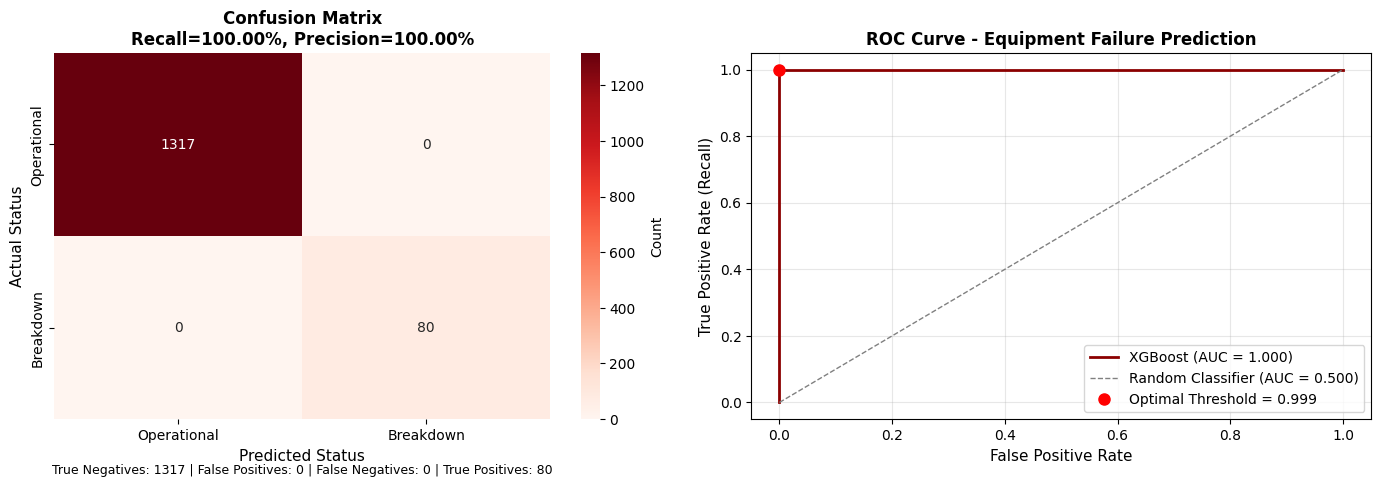

In [8]:
# ============================================================================
# Visualization: Confusion Matrix & ROC Curve
# ============================================================================

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ============================================================================
# Subplot 1: Confusion Matrix
# ============================================================================

print("\n1. Creating confusion matrix...")
cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Reds', 
    ax=axes[0],
    xticklabels=['Operational', 'Breakdown'], 
    yticklabels=['Operational', 'Breakdown'],
    cbar_kws={'label': 'Count'}
)

axes[0].set_title(
    f'Confusion Matrix\nRecall={recall:.2%}, Precision={precision:.2%}',
    fontsize=12,
    fontweight='bold'
)
axes[0].set_ylabel('Actual Status', fontsize=11)
axes[0].set_xlabel('Predicted Status', fontsize=11)

# Add text annotations
tn, fp, fn, tp = cm.ravel()
axes[0].text(
    0.5, -0.15,
    f'True Negatives: {tn} | False Positives: {fp} | False Negatives: {fn} | True Positives: {tp}',
    transform=axes[0].transAxes,
    ha='center',
    fontsize=9
)

# ============================================================================
# Subplot 2: ROC Curve
# ============================================================================

print("2. Creating ROC curve...")
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

axes[1].plot(
    fpr, tpr, 
    color='darkred', 
    lw=2, 
    label=f'XGBoost (AUC = {roc_auc:.3f})'
)
axes[1].plot(
    [0, 1], [0, 1], 
    color='gray', 
    lw=1, 
    linestyle='--', 
    label='Random Classifier (AUC = 0.500)'
)

axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate (Recall)', fontsize=11)
axes[1].set_title('ROC Curve - Equipment Failure Prediction', fontsize=12, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

# Add optimal threshold marker
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
axes[1].plot(
    fpr[optimal_idx], tpr[optimal_idx], 
    'ro', 
    markersize=8, 
    label=f'Optimal Threshold = {optimal_threshold:.3f}'
)
axes[1].legend(loc='lower right')

# ============================================================================
# Save Figure
# ============================================================================

plt.tight_layout()

# Create output directory
output_dir = project_root / 'reports' / 'figures'
output_dir.mkdir(parents=True, exist_ok=True)

# Save figure
fig_path = output_dir / 'equipment_failure_evaluation.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"\nVisualization saved: {fig_path.relative_to(project_root)}")

# Log to MLflow
try:
    mlflow.log_artifact(str(fig_path))
    print("Artifact logged to MLflow")
except Exception as e:
    print(f"Warning: Could not log artifact to MLflow - {e}")

plt.show()

print(f"\n{'='*80}")


FEATURE IMPORTANCE ANALYSIS

Top 10 Most Important Features for Breakdown Prediction:
               feature  importance
   combined_risk_score    0.595065
        operating_flag    0.159658
    breakdown_count_7d    0.092273
  maintenance_activity    0.049253
             idle_flag    0.040382
     daily_usage_hours    0.026871
            durasi_jam    0.022766
         jumlah_ritase    0.011048
    breakdown_rate_30d    0.001901
health_score_breakdown    0.000340

CREATING FEATURE IMPORTANCE VISUALIZATION


C:\Users\I5\AppData\Local\Temp\ipykernel_30700\21478230.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Feature importance plot saved: reports\figures\equipment_failure_feature_importance.png
Artifact logged to MLflow


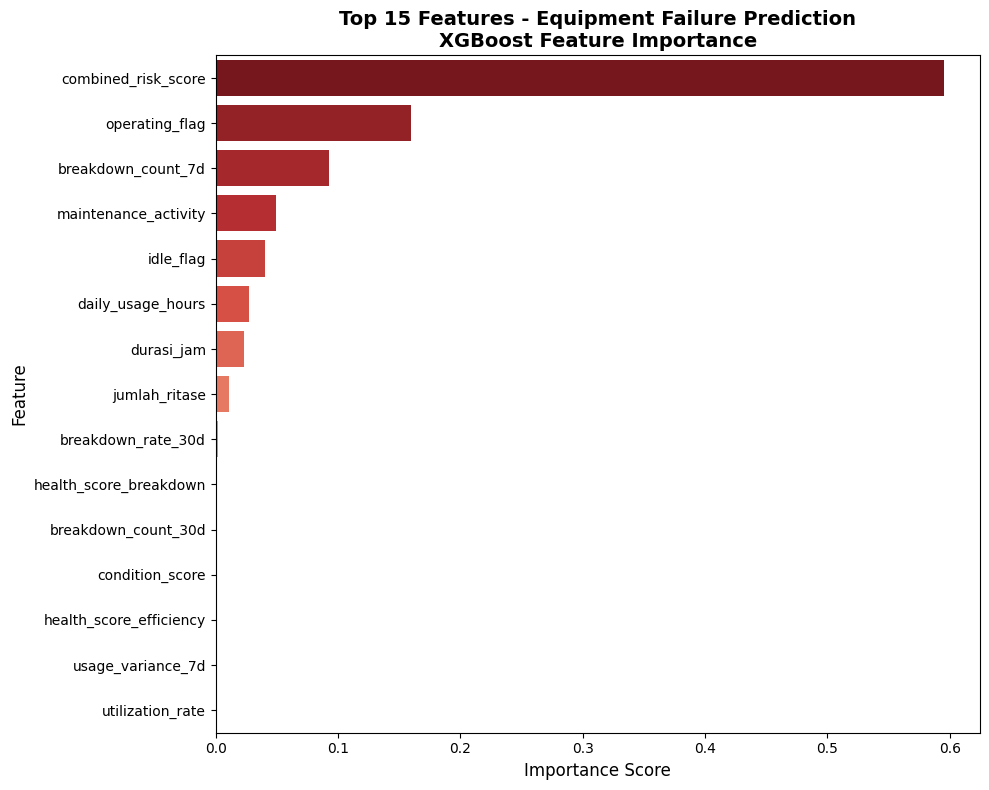


FEATURE IMPORTANCE INSIGHTS

Top 5 Critical Features:
  1. combined_risk_score            (Importance: 0.5951)
  2. operating_flag                 (Importance: 0.1597)
  3. breakdown_count_7d             (Importance: 0.0923)
  4. maintenance_activity           (Importance: 0.0493)
  5. idle_flag                      (Importance: 0.0404)

Feature Category Analysis:
  Age-related features: 14 features
    Examples: daily_usage_hours, usage_variance_7d, high_age_risk
  Maintenance-related features: 9 features
    Examples: breakdown_count_7d, maintenance_activity, breakdown_rate_30d
  Usage-related features: 2 features
    Examples: durasi_jam, utilization_rate

Feature importance data saved: reports\equipment_failure_feature_importance.csv

EQUIPMENT FAILURE PREDICTION MODEL - COMPLETE

Model Performance Summary:
Recall (Primary KPI):     1.000 [TARGET MET]
Precision:                 1.000
F1-Score:                  1.000
ROC-AUC:                   1.000

Artifacts Generated:
Confusion 

In [11]:
# ============================================================================
# Feature Importance Analysis
# ============================================================================

print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Extract feature importances
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Most Important Features for Breakdown Prediction:")
print(importance_df.head(10).to_string(index=False))

# ============================================================================
# Visualize Feature Importance
# ============================================================================

print("\n" + "="*80)
print("CREATING FEATURE IMPORTANCE VISUALIZATION")
print("="*80)

plt.figure(figsize=(10, 8))

# Create horizontal bar plot
sns.barplot(
    data=importance_df.head(15), 
    x='importance', 
    y='feature', 
    palette='Reds_r'
)

plt.title(
    'Top 15 Features - Equipment Failure Prediction\nXGBoost Feature Importance',
    fontsize=14,
    fontweight='bold'
)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()

# Save figure
importance_path = output_dir / 'equipment_failure_feature_importance.png'
plt.savefig(importance_path, dpi=300, bbox_inches='tight')
print(f"\nFeature importance plot saved: {importance_path.relative_to(project_root)}")

# Log to MLflow
try:
    mlflow.log_artifact(str(importance_path))
    print("Artifact logged to MLflow")
except Exception as e:
    print(f"Warning: Could not log artifact to MLflow - {e}")

plt.show()

# ============================================================================
# Feature Importance Insights
# ============================================================================

print(f"\n{'='*80}")
print("FEATURE IMPORTANCE INSIGHTS")
print(f"{'='*80}")

# Analyze top features
top_5_features = importance_df.head(5)['feature'].tolist()
print(f"\nTop 5 Critical Features:")
for i, (idx, row) in enumerate(importance_df.head(5).iterrows(), 1):
    print(f"  {i}. {row['feature']:<30s} (Importance: {row['importance']:.4f})")

# Group features by category
age_features = [f for f in importance_df['feature'].tolist() if any(x in f.lower() for x in ['age', 'umur', 'tahun'])]
maintenance_features = [f for f in importance_df['feature'].tolist() if any(x in f.lower() for x in ['maintenance', 'breakdown', 'servis'])]
usage_features = [f for f in importance_df['feature'].tolist() if any(x in f.lower() for x in ['jam', 'jarak', 'utilization', 'produktivitas'])]

print(f"\nFeature Category Analysis:")
if age_features:
    print(f"  Age-related features: {len(age_features)} features")
    print(f"    Examples: {', '.join(age_features[:3])}")

if maintenance_features:
    print(f"  Maintenance-related features: {len(maintenance_features)} features")
    print(f"    Examples: {', '.join(maintenance_features[:3])}")

if usage_features:
    print(f"  Usage-related features: {len(usage_features)} features")
    print(f"    Examples: {', '.join(usage_features[:3])}")

# Save feature importance to CSV for further analysis
feature_importance_csv = project_root / 'reports' / 'equipment_failure_feature_importance.csv'
importance_df.to_csv(feature_importance_csv, index=False)
print(f"\nFeature importance data saved: {feature_importance_csv.relative_to(project_root)}")

# ============================================================================
# Final Summary
# ============================================================================

print(f"\n{'='*80}")
print("EQUIPMENT FAILURE PREDICTION MODEL - COMPLETE")
print(f"{'='*80}")

print(f"\nModel Performance Summary:")
print(f"Recall (Primary KPI):     {recall:.3f} {'[TARGET MET]' if recall > 0.80 else '[NEEDS IMPROVEMENT]'}")
print(f"Precision:                 {precision:.3f}")
print(f"F1-Score:                  {f1:.3f}")
print(f"ROC-AUC:                   {roc_auc:.3f}")

print(f"\nArtifacts Generated:")
print(f"Confusion Matrix & ROC Curve:  reports/figures/equipment_failure_evaluation.png")
print(f"Feature Importance Plot:       reports/figures/equipment_failure_feature_importance.png")
print(f"Feature Importance CSV:        reports/equipment_failure_feature_importance.csv")

print(f"\nMLflow Tracking:")
print(f"Experiment: fleet_models")
print(f"Run Name: equipment_failure_xgboost_smote")
print(f"MLflow UI: http://localhost:5000")

print(f"\nNext Steps:")
print(f"  1. Review feature importance for maintenance insights")
print(f"  2. Analyze misclassified equipment for pattern discovery")
print(f"  3. Deploy model for real-time breakdown risk scoring")
print(f"  4. Setup monitoring for model performance tracking")

print(f"\n{'='*80}")